In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

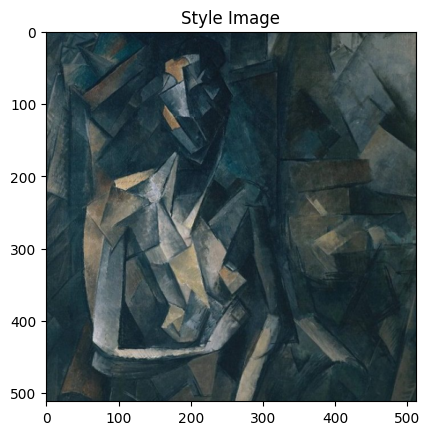

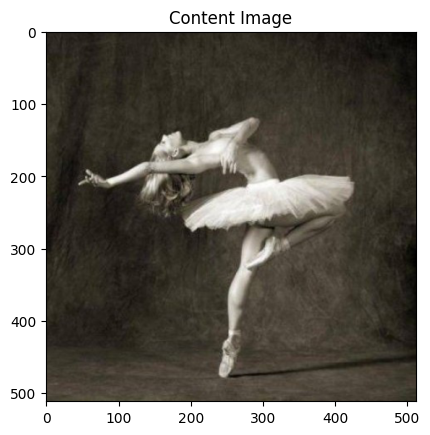

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')
plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach() ## gram loss
    #     self.mean_target, self.var_target = compute_variance_and_mean(target_feature)
    #     self.mean_target = self.mean_target.detach()
    #     self.var_target = self.var_target.detach()


    # def forward(self, input):
    #         mean, var = compute_variance_and_mean(input)
    #         self.loss = F.mse_loss(mean, self.mean_target) + F.mse_loss(var, self.var_target)
    #         return input

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
def compute_variance_and_mean(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)
    mean_target = torch.mean(input, dim=[2, 3], keepdim=True)
    tensor = input.view(a * b, c * d)
    var_target = torch.var(tensor, dim=1, keepdim=True).view(a, b, 1, 1)
    return mean_target, var_target

In [ ]:
from torchvision.models import VGG19_Weights

cnn = models.vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 67.4MB/s]


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['pool_16']
style_layers_default = ['conv_3']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)


        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

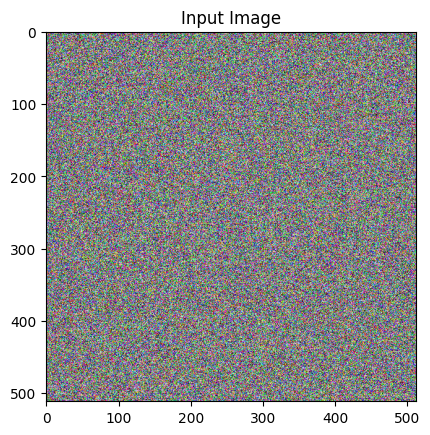

In [ ]:
# input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=1800,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            # for cl in content_losses:
            #     content_score += cl.loss

            style_score *= style_weight
            # content_score *= content_weight

            # loss = style_score + content_score
            # loss.backward()
            style_score.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                # print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                #     style_score.item(), content_score.item()))
                print(style_score.item())

            return style_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Building the style transfer model..
Optimizing..
run [50]:
3.089339256286621
run [100]:
0.7174170613288879


KeyboardInterrupt: ignored

In [ ]:
from PIL import Image
import torch
!pip install diffusers
!pip install transformers

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder").to(device)
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 113.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 89.9 MB/s eta 0:00:00


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [ ]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [ ]:
batch_size = 1
height = imsize
width = imsize
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
prompt = ["a horse"]
batch_size = len(prompt)

In [ ]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
)
latents = latents.to(device)

<ipython-input-214-cd488a221167>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


In [ ]:
latents = latents * scheduler.init_noise_sigma

In [ ]:
def generate_clean_img(i, input):
  n_input = input
  for t in scheduler.timesteps[i:]:
        with torch.no_grad():
            noisy_residual = unet(n_input, t, text_embeddings).sample
        previous_noisy_sample = scheduler.step(noisy_residual, t, n_input).prev_sample
        n_input = previous_noisy_sample
  return latent_to_img(n_input)

In [ ]:
def latent_to_img(input):
  # scale and decode the image latents with vae
  input = 1 / 0.18215 * input
  with torch.no_grad():
    res = vae.decode(input).sample
  return (res / 2 + 0.5).clamp(0, 1)

In [ ]:
def pil_to_latents(image):
    '''
    Function to convert image to latents
    '''
    return vae.encode(image).latent_dist.sample() * 0.18215

In [ ]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

style_model, style_losses, content_losses = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img)
style_model.eval()
style_model.requires_grad_(False)
style_weight=1000000
i = -1
for t in tqdm(scheduler.timesteps):
    i += 1
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)
    # predict the noise residual
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample


    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    # img.requires_grad = True
    # optimizer = get_input_optimizer(img)
    # optimizer.zero_grad()
    # def insider():
    #   style_model(img)
    #   style_score = 0
    #   for sl in style_losses:
    #     style_score += sl.loss
    #   style_score *= style_weight
    #   style_score.backward()
    #   return style_score
    # optimizer.step(insider)
    # latents = pil_to_latents(img)


OutOfMemoryError: ignored

In [ ]:
image = latent_to_img(latents)

In [ ]:
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

AttributeError: ignored

In [ ]:
torch.cuda.empty_cache()